Sta 663 - Statistical Computing and Computation - Midterm 1
-----------
Due Monday, February 28th by 5:00 pm.

## Setup

In [1]:
# Load necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import optimize
from scipy.optimize import Bounds
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
d1 = pd.read_csv("data/d1.csv")
d2 = pd.read_csv("data/d2.csv")
d3 = pd.read_csv("data/d3.csv")

Below is the scatter plots of all three dataset, which could give us a sense of how the points distributed in the whole dataset, and would be helpful for us to determine the x and y range in further observations.

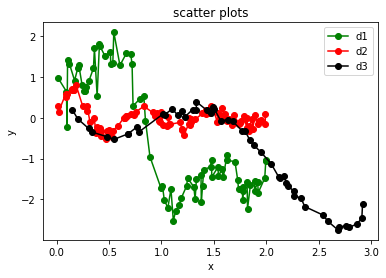

In [3]:
## scatter plots of all three datasets
plt.plot(d1.loc[:, 'x'], d1.loc[:, 'y'], '-ok', color = 'green', label = 'd1')
plt.plot(d2.loc[:, 'x'], d2.loc[:, 'y'], '-ok', color = 'red', label = 'd2')
plt.plot(d3.loc[:, 'x'], d3.loc[:, 'y'], '-ok', color = 'black', label = 'd3')

plt.title('scatter plots')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [77]:
# Helper functions
# define covaraince function 
def cov(X1, X2, parameters):
    """
    Return the covariance matrix of the input X1 and X2 based on the parameters
    
    Keyword arguments:
    X1 -- a array of numbers
    X2 -- a array of numbers
    parameters -- including all three parameters of sigma2_n, sigma2_s and l
    """
    sigma2_n, sigma2_s, l = parameters
    col_X1 = len(X1)
    X1 = X1.reshape((col_X1, 1))
    col_X2 = len(X2)
    X2 = X2.reshape((1, col_X2))
    # distance calculation
    cov_matrix = (X1 - X2)**2  
    # covariance calculation
    covariance = (sigma2_n * np.eye(col_X1,col_X2)) + (sigma2_s * np.exp(-(cov_matrix) * 1/(2*l)))
    return covariance

## Task 1 - Model fitting

In this task, firstly should determine which is the variable x and which is the variable y of the input d dataset and convert it to array for future calculations. Afterwards, defining the log likelihood function and calculating covariance from helper function. In this case, X and Y could be directly used, since we have already set them. Note that here we should use the argmin - L(y) function in order to do the future optimize.minimize. Before running the optimization model, random seed should be set for all random number generation within the function and all lower bound should be made sure that they are all greater than 0, if not, then output bounds error.\
Optimization models iterate in the for loop to ensure the n_init times. The bounds for each parameter should be seperately selected from lb and ub. In this case, we use optimize.Bounds. Note that in order to make the process simpler, I fixed the lb and ub of the first parameter sigma2_n, 0.1. Using optimize.minimize function to do the optimization models, the input function should be log likelihood function we defined above, and start from we uniformly randomly generated from lower bound and upper bound. Here I used the method is Nelder-Mead and bounds should be set by previous classes by using optimize.Bounds. \
After running the optimization models, all the successful result should be stored including relative successful parameters and successful negative log likelihood value, and the final MLE should return the three parameters from the minimum negative log likelihood value. Note that after obtaining all results, we should check if all the results are fail, if they are, then raise the RuntimeError, and in the whole optimization process, we should set "try" and "except" to check other errors. 

In [80]:
def fit(d, n_init, lb = [0.1, 1e-6, 1e-6], ub = [0.1, 5, 2], seed = 1):
    """
    Return the list of sigma2_n, sigma2_s and l parameters from the optimized MLE value
    
    Keyword argument:
    d -- a dataset contains x and y
    n_init -- a number indicates the running times of optimization function
    lb -- a list of lower bounds of all parameters
    ub -- a list of upper bounds of all parameters
    seed -- initial seed setting and default is 1
    """
    
    # convert d to dataframe
    d = pd.DataFrame(d)
    # drop the rows where at least one element is missing
    d.dropna()
    
    # determine which variable is x and which is y and convert to array
    Y = np.array(d.y)
    X = np.array(d.x)
    
    # define the likelihood function
    def neg_likelihood(parameters):
        covariance = cov(X, X, parameters)
        mu = 0 
        L_y = 1/2 * (len(X)*np.log(2*np.pi) + np.log(np.linalg.det(covariance)) + (Y - mu).T @ np.linalg.inv(covariance) @ (Y - mu))
        return L_y

    # set random seed
    rng = np.random.default_rng(seed)
    
    result = [] 
    result_log = [] 
    result_par = [] 
    
    try:
        # make sure all lower bounds for parameters are greater than 0
        if all(i >= 0 for i in lb) == True: 
           # optimization for the minimum of -log likelihood 
           for i in range(n_init):
            # set optimization bound
            bounds = optimize.Bounds(lb, ub, keep_feasible = True)
            x0 = np.concatenate([rng.uniform(lb[i], ub[i], 1) for i in range(len(lb))])
            # optimization model 
            optimization = optimize.minimize(fun = neg_likelihood, x0 = x0, method = "Nelder-Mead", bounds = bounds) 
            # store the successful optimization results
            result.append(optimization.success)
            if result != 0:
                # store relative successful parameters
                result_par.append(optimization.x)
                # store the successful negative log likelihood value
                result_log.append(optimization.fun)
            # check if all is fail, and if not, find the MLE
            if sum(result) == 0:
                raise RuntimeError("All optimization attempts are fail")    
            else:
                MLE = result_par[np.argmin(result_log)]
                    
        else:
            raise ValueError("bounds should be positive!")
    
    except OverflowError as err:
        print(f"{type(err).__name__}: {err}")
        
    return MLE

In [81]:
theta1 = fit(d1, 10); print(theta1) # Add arguments as needed
theta2 = fit(d2, 10); print(theta2) # Add arguments as needed
theta3 = fit(d3, 10); print(theta3) # Add arguments as needed

[0.1        1.82599518 0.08997171]
[0.1        0.06205816 0.02229263]
[0.1        2.03605411 0.59864846]


## Task 2 - Prediction

In this task, the first step is similar as it in task 1, drop na value in d dataset, find the x and y variables and convert them to array. The next step is to use the covariance function to calculate mu_star and sigma_star, and apply them in multivariate normal distribution to generate the predicted y. Note that in multivariate normal function, we could use size parameter to set draws to avoid repeated calls. \
The last step is to combine new x values and all draws of relative predicted y and make them as a whole dataframe. 

In [82]:
def predict(d, theta, x_p , n_draws = 10, seed = 1):
    """
    Return a dataset with new x values and all draws of relative predicted y
    
    Keyword arguments:
    d -- a dataset contains x and y
    theta -- the list of the three parameters obtained from task 1
    x_p -- the array of new x
    n_draws -- the number of draws to make from the conditional distribution
    seed -- a seed value and default is 1
    """
    # convert d to dataframe
    d = pd.DataFrame(d)
    # drop the rows where at least one element is missing
    d.dropna()
    
    # determine which variable is x and which is y and convert to array
    Y = np.array(d.y)
    X = np.array(d.x)
    
    # calculate mean and variance
    mu = 0
    mu_p = 0
    mu_star = mu_p + (cov(x_p, X, theta) @ np.linalg.inv(cov(X, X, theta)) @ (Y - mu))
    sigma_star = cov(x_p, x_p, theta) - (cov(x_p, X, theta) @ np.linalg.inv(cov(X, X, theta)) @ cov(x_p, X, theta).T)
    
    # set random seed
    rng = np.random.default_rng(seed)
    
    # simulate y_pred with n_draws in dataframe   
    y_pred_x = pd.DataFrame({'x_p': x_p})
    y_pred = pd.DataFrame(rng.multivariate_normal(mu_star, sigma_star, size = n_draws)).T
    # rename y_pred
    y_pred.columns = ['draw' + str(i + 1) for i in range(len(y_pred.columns))]
    # combine final dataframe
    y_pred_final = pd.concat([y_pred_x, y_pred], axis = 1)

    return y_pred_final

In [83]:
x1_min, x1_max = min(d1['x']), max(d1['x'])
x2_min, x2_max = min(d2['x']), max(d2['x'])
x3_min, x3_max = min(d3['x']), max(d3['x'])
pred1 = predict(d1, theta1, np.linspace(x1_min, x1_max, 100), 100) # Add arguments as needed
pred2 = predict(d2, theta2, np.linspace(x2_min, x2_max, 100), 100) # Add arguments as needed
pred3 = predict(d3, theta3, np.linspace(x3_min, x3_max, 100), 100) # Add arguments as needed

In [84]:
pred1

,x_p,draw1,draw2,draw3,draw4,draw5,draw6,draw7,draw8,draw9,...,draw91,draw92,draw93,draw94,draw95,draw96,draw97,draw98,draw99,draw100
0,0.015744,0.968680,0.968680,0.968680,0.968680,0.968680,0.968680,0.968680,0.968680,0.968680,...,0.968680,0.968680,0.968680,0.968680,0.968680,0.968680,0.968680,0.968680,0.968680,0.968680
1,0.035734,0.732392,0.646427,0.577942,0.550350,0.642212,0.766097,0.610941,0.602955,0.708343,...,0.570640,0.538587,0.844782,0.542158,0.576710,0.609308,0.574464,0.956443,0.686614,0.668161
2,0.055724,-0.179337,-0.237929,-0.273519,-0.294987,-0.235309,-0.147448,-0.256381,-0.266177,-0.193817,...,-0.274172,-0.302653,-0.093377,-0.300260,-0.278559,-0.255160,-0.275474,-0.014720,-0.213376,-0.221903
3,0.075714,1.438030,1.402743,1.388170,1.373063,1.407869,1.463991,1.395394,1.386684,1.431180,...,1.391676,1.368931,1.497755,1.370356,1.382205,1.397866,1.387463,1.546489,1.415268,1.413495
4,0.095704,1.336623,1.310944,1.307978,1.293666,1.318815,1.365337,1.310148,1.300571,1.335041,...,1.316975,1.291640,1.392872,1.292520,1.299774,1.314420,1.308545,1.429278,1.316726,1.320596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.914788,-1.836459,-1.815786,-1.707073,-1.650552,-2.027146,-1.761927,-1.547796,-2.203364,-1.958030,...,-1.541005,-2.140796,-2.081032,-1.446915,-1.500003,-1.882090,-0.892997,-1.742298,-1.337946,-1.334249
96,1.934778,-0.903838,-2.212454,-1.689409,-1.507449,-1.773235,-2.500253,-1.427818,-1.871030,-1.974754,...,-1.500030,-1.625178,-1.603373,-1.480107,-1.871202,-1.973829,-1.118751,-1.154345,-1.118803,-1.375423
97,1.954768,-1.490783,-1.425772,-1.261689,-1.088372,-1.753808,-1.738388,-1.117342,-1.855962,-1.629233,...,-1.375300,-1.654805,-1.106352,-1.443651,-1.302970,-1.399519,-1.077863,-1.009970,-1.463028,-1.618522
98,1.974758,-1.391908,-1.352354,-1.535835,-2.044428,-1.806711,-1.148005,-1.037020,-1.823735,-1.651297,...,-0.992218,-1.154847,-1.483772,-0.807006,-1.315329,-1.777993,-1.496949,-1.387552,-1.560433,-0.895842


In [85]:
pred2

,x_p,draw1,draw2,draw3,draw4,draw5,draw6,draw7,draw8,draw9,...,draw91,draw92,draw93,draw94,draw95,draw96,draw97,draw98,draw99,draw100
0,0.018291,0.289786,0.289786,0.289786,0.289786,0.289786,0.289786,0.289786,0.289786,0.289786,...,0.289786,0.289786,0.289786,0.289786,0.289786,0.289786,0.289786,0.289786,0.289786,0.289786
1,0.038214,0.202823,0.212910,0.190310,0.174461,0.210637,0.160501,0.205003,0.136884,0.191380,...,0.209307,0.203898,0.206844,0.171123,0.191812,0.151569,0.209110,0.177591,0.216170,0.220031
2,0.058137,0.510120,0.478148,0.524928,0.551331,0.501600,0.568778,0.542331,0.622116,0.522903,...,0.505034,0.531061,0.470963,0.568077,0.512962,0.572286,0.522565,0.538659,0.499770,0.497205
3,0.078060,0.476121,0.459812,0.483076,0.494823,0.473531,0.502204,0.496351,0.528138,0.481545,...,0.474454,0.489411,0.454087,0.504664,0.476370,0.501736,0.484750,0.488437,0.472784,0.472577
4,0.097982,0.571412,0.572368,0.571001,0.570419,0.571456,0.570065,0.570001,0.568627,0.571149,...,0.571459,0.570484,0.572793,0.569762,0.571436,0.570223,0.570785,0.570783,0.571517,0.571462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.910953,-0.101883,-0.119344,-0.071395,-0.118652,-0.153318,-0.077148,-0.066162,-0.084930,-0.104564,...,-0.084829,-0.120101,-0.097116,-0.086115,-0.067046,-0.111929,-0.116543,-0.105559,-0.115895,-0.110045
96,1.930876,-0.075991,-0.083330,-0.062425,-0.083665,-0.105708,-0.069191,-0.061786,-0.068566,-0.076637,...,-0.071068,-0.084547,-0.075817,-0.071615,-0.059172,-0.081804,-0.081751,-0.078628,-0.083017,-0.082893
97,1.950798,-0.064052,-0.061919,-0.068539,-0.061676,-0.052341,-0.064939,-0.067988,-0.066281,-0.064096,...,-0.064829,-0.061031,-0.063291,-0.064570,-0.069913,-0.062005,-0.062484,-0.062885,-0.061764,-0.060840
98,1.970721,-0.172811,-0.176344,-0.151738,-0.178175,-0.240100,-0.181279,-0.164944,-0.167309,-0.167647,...,-0.176590,-0.188959,-0.187032,-0.179588,-0.143526,-0.177469,-0.175176,-0.179762,-0.178250,-0.193696


In [86]:
pred3

,x_p,draw1,draw2,draw3,draw4,draw5,draw6,draw7,draw8,draw9,...,draw91,draw92,draw93,draw94,draw95,draw96,draw97,draw98,draw99,draw100
0,0.150440,0.194669,0.194669,0.194669,0.194669,0.194669,0.194669,0.194669,0.194669,0.194669,...,0.194669,0.194669,0.194669,0.194669,0.194669,0.194669,0.194669,0.194669,0.194669,0.194669
1,0.178365,0.002885,0.008791,0.016589,-0.003906,0.013591,0.030152,-0.001927,-0.036482,-0.039244,...,-0.011126,-0.001081,-0.024625,0.008227,-0.010462,0.030038,0.013911,0.008109,0.019245,0.011017
2,0.206290,-0.151273,-0.132518,-0.084926,-0.180541,-0.124895,-0.046836,-0.148621,-0.282708,-0.302156,...,-0.203286,-0.175696,-0.250706,-0.136623,-0.194595,-0.053147,-0.115846,-0.138472,-0.103262,-0.123720
3,0.234216,-0.243888,-0.227364,-0.171417,-0.275759,-0.224769,-0.138679,-0.232984,-0.366904,-0.390573,...,-0.295715,-0.272855,-0.341624,-0.233272,-0.283612,-0.148188,-0.212318,-0.235195,-0.203346,-0.218416
4,0.262141,-0.298369,-0.284703,-0.148201,-0.373905,-0.305230,-0.106364,-0.253328,-0.472059,-0.532220,...,-0.393369,-0.372800,-0.467621,-0.312866,-0.350646,-0.143638,-0.268400,-0.310661,-0.270808,-0.268275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.803350,-1.902331,-2.659374,-2.888350,-2.448962,-3.109362,-2.650282,-1.577891,-3.131944,-2.670366,...,-2.153036,-2.654869,-2.306833,-2.327760,-2.977828,-2.517375,-2.177252,-2.601143,-2.865305,-2.367704
96,2.831275,-2.615098,-2.571378,-2.810879,-2.549913,-2.572483,-2.449013,-2.524550,-2.645091,-2.719334,...,-2.698714,-2.581021,-2.964793,-2.392245,-2.340481,-2.204562,-2.754279,-2.047750,-2.561677,-2.143464
97,2.859200,-2.399143,-2.583498,-2.698345,-2.518991,-2.812207,-3.245560,-2.108800,-2.526469,-2.826840,...,-1.968225,-1.973711,-2.751332,-1.959734,-2.941539,-2.352680,-2.640004,-2.652670,-2.958091,-1.581298
98,2.887126,-2.357047,-2.240383,-2.816855,-2.592672,-2.693801,-2.070526,-2.641443,-2.561099,-2.423314,...,-2.527606,-2.260963,-2.750577,-2.295022,-2.390349,-2.488266,-1.889553,-2.034788,-2.600373,-2.149559


## Task 3 - Plotting

In this task, we will plot the results from task2 and the additional 95% confidence interval for predicted y. First, create a dataframe which contains the new x value, means of prediction y across all draws, the lower bound of 95% confidence interval and upper bound of 95% confidence interval. After that, we could start to plot. Note that here if no d input parameter, then only y_pred and its confidence interval, if the user has the d input parameter, then the plot should provide the original d observations. Using plot and fill_between to plot the means value with shaded region representing a 95% confidence interval, additionally, we could use scatter plot to include the original observations. 

In [87]:
def plot_gp(pred, d = None):
    """
    Return a plot with mean and 95% confidence interval of prediction y, optionally, includes the original observations
    
    Keyword arguments:
    pred -- a prediction dataframe obtained from task 2 (predict() function)
    d -- a dataframe with data observations, default is none and will not show in the final plot  
    """
    # creat dataframe for mean and 95% confidence interval 
    df = (pd.DataFrame()
          .assign(x_pre = pred.iloc[:,0],
                  mean_pred = pred.iloc[:,1:].mean(axis = 1),
                  CI_lower = np.percentile(pred.iloc[:,1:], 2.5, axis = 1),
                  CI_upper = np.percentile(pred.iloc[:,1:], 97.5, axis = 1)
                 )
         )
    # start plot
    # if no d parameter, then only y_pred and its CI, but if has d parameter, then shows d observations
    if d is None:
        fig, ax = plt.subplots(figsize = (5,5))
        ax.plot(df.iloc[:,0], df.iloc[:,1], color = 'red', alpha = 1)
        ax.fill_between(df.iloc[:,0], df.iloc[:,2], df.iloc[:,3], color ='pink', alpha=.8)
        plt.title("mean and 95% CI for predicted y")
        plt.xlabel("x_pred value")
        plt.ylabel("y_pred mean and 95% CI")
        plt.show()
    else:
        fig, ax = plt.subplots(figsize = (5,5))
        ax.plot(df.iloc[:,0], df.iloc[:,1], color = 'red', alpha = 1)
        ax.plot(d.x, d.y, 'o', color = 'black', alpha = 0.5)
        ax.fill_between(df.iloc[:,0], df.iloc[:,2], df.iloc[:,3], color ='pink', alpha=.8)
        plt.title("mean and 95% CI for predicted y & original observations")
        plt.xlabel("x_pred value")
        plt.ylabel("y_pred mean, original y and 95% CI")
        plt.show()
    pass

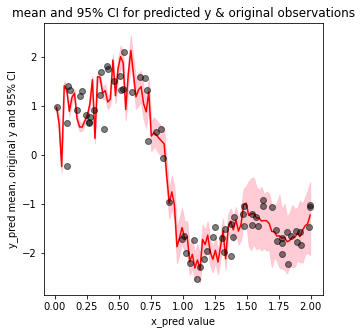

In [88]:
plot_gp(pred1, d1)

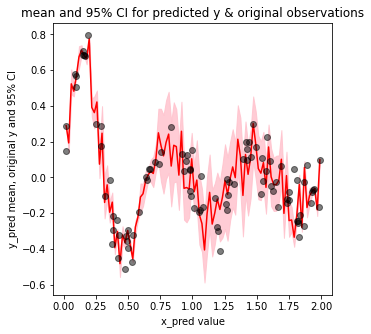

In [89]:
plot_gp(pred2, d2)

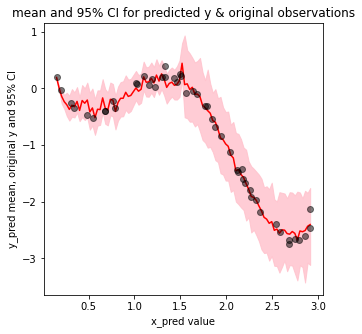

In [90]:
plot_gp(pred3, d3)